In [4]:
import pandas as pd
import os , json
from pymongo import MongoClient
import matplotlib.pyplot as plt
import re, pprint, pickle

In [8]:
from os import listdir
from os.path import isfile, join

In [5]:
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

In [6]:
import spacy
import scispacy

##### Mongo DB connection

In [9]:
#log into COVID19 database on AWS
config = {
  'host': '184.169.174.230:27017',
  'username': 'xin',
  'password': 'passw0rd',
  'authSource': 'COVID19'
}

client = MongoClient(**config)

db = client.COVID19

In [13]:
path = 'comm_use_subset/comm_use_subset/pdf_json'

#get all file names under this directory
files = [f for f in os.listdir(path) if isfile(join(path, f))]

#get full path directory
file_path = list(path +'/'+ files[i] for i in range(len(files)))

In [14]:
#total papers in dataset
len(files)

9918

In [282]:
#Create collection
#db.create_collection('subset')

Collection(Database(MongoClient(host=['184.169.174.230:27017'], document_class=dict, tz_aware=False, connect=True, authsource='COVID19'), 'COVID19'), 'subset')

In [15]:
#Read json file into list
whole_list = []
for i in range(len(file_path)):
    with open  (file_path[i]) as f:
        data = json.load(f)
        whole_list.append(data)

In [30]:
# insert data into dataframe, commented out to prevent multiple insert
# db.subset.insert_many(whole_list)

In [17]:
#Load all data into mongodb
db.subset.count_documents({})

9918

In [145]:
#Each paper was sectioned into several text subfield, this step is to concat them together.
agg = db.subset.aggregate([
   { '$project': { 'whole_text': { '$concatArrays': '$body_text.text' } } }
])
# returned_abs = list(db.subset.find({},{'abstract.text':1, '_id':0}))
agg_abs = db.subset.aggregate([
   { '$project': { 'abstract': { '$concatArrays': '$abstract.text' } } }
])

In [146]:
df = pd.DataFrame(list(agg))

In [153]:
returned = list(db.subset.find({},{'metadata.title':1, '_id':0}))#getting title results from database
df['title'] = list(item['metadata']['title'] for item in returned)#remove the parenphasis

In [169]:
#joining paragraphs in list
def concat_list(text):
    return ' '.join(text)
df.whole_text = df.whole_text.apply(concat_list)

In [217]:
df.to_pickle('df_text.pkl')

In [170]:
df

,_id,whole_text,title
0,5ebeb947e7549a35232c1ba9,"Porcine epidemic diarrhea virus (PEDV), which ...",Neutralizing antibodies against porcine epidem...
1,5ebeb947e7549a35232c1baa,"Generation of rNDVs expressing S1, S2 or S pro...",A Recombinant Newcastle Disease Virus (NDV) Ex...
2,5ebeb947e7549a35232c1bab,The incidence of complete Achilles tendon rupt...,GP-confirmed complete Achilles tendon rupture ...
3,5ebeb947e7549a35232c1bac,Arenaviruses are enveloped RNA viruses with bi...,Potent Inhibition of Junín Virus Infection by ...
4,5ebeb947e7549a35232c1bad,"In this study, the anti-dengue activity of nic...",2 convergent Research center for emerging Viru...
...,...,...,...
9913,5ebeb948e7549a35232c4262,Early nutritional environment affects long ter...,Lipidome profiles of postnatal day 2 vaginal s...
9914,5ebeb948e7549a35232c4263,Syphilis is a sexually transmitted disease (ST...,"Secondary Syphilis in Cali, Colombia: New Conc..."
9915,5ebeb948e7549a35232c4264,Scientific RepoRts | 6:21878 | DOI: 10 .1038/s...,Replication and shedding of MERS- CoV in Jamai...
9916,5ebeb948e7549a35232c4265,Arenaviruses are enveloped RNA viruses contain...,Role of the ERK1/2 Signaling Pathway in the Re...


##### EDA

In [172]:
len_list = df.whole_text.apply(len)

In [173]:
len_list

0       23728
1       45631
2       18385
3       19988
4       27473
        ...  
9913    27088
9914    35795
9915    17942
9916    30748
9917    19206
Name: whole_text, Length: 9918, dtype: int64

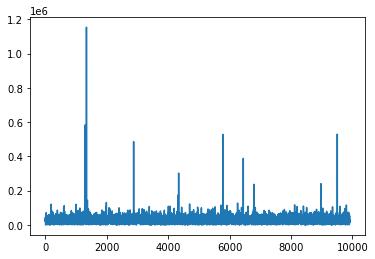

In [166]:
plt.plot(len_list)

(array([4.051e+03, 4.782e+03, 9.030e+02, 1.320e+02, 3.000e+01, 8.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([1.0000000e+00, 2.3080900e+04, 4.6160800e+04, 6.9240700e+04,
        9.2320600e+04, 1.1540050e+05, 1.3848040e+05, 1.6156030e+05,
        1.8464020e+05, 2.0772010e+05, 2.3080000e+05, 2.5387990e+05,
        2.7695980e+05, 3.0003970e+05, 3.2311960e+05, 3.4619950e+05,
        3.6927940e+05, 3.9235930e+05, 4.1543920e+05, 4.3851910e+05,
        4.6159900e+05, 4.8467890e+05

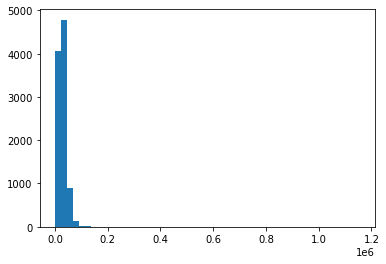

In [168]:
plt.hist(len_list,bins=50)#looks at the distribution of paper length. Most papers are around 4000 -5000 words